In [1]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import segmentation_models_pytorch as smp

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Segformer(
    encoder_name="mit_b0",      # Use the MIT-B0 encoder for SegFormer
    encoder_weights="imagenet", # Pretrained on ImageNet
    in_channels=1,              # Input channels (e.g., grayscale)
    classes=1                   # Number of output classes
).to(device)

In [3]:
from levee_hunter.levees_dataset import LeveesDataset

dataset = LeveesDataset(
    images_dir='../data/processed/1m_1024/images',
    masks_dir='../data/processed/1m_1024/masks',
    transform=None,
    weighted=True,
    )

len(dataset)

/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/share/gpu5/pmucha/fathom/levee-hunter/levee_hunter/augmentations.py:16: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
/share/gpu5/pmucha/fathom/levee-hunter/levee_hunter/augmentations.py:19: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(
/share/gpu5/pmucha/fathom/levee-hu

1626

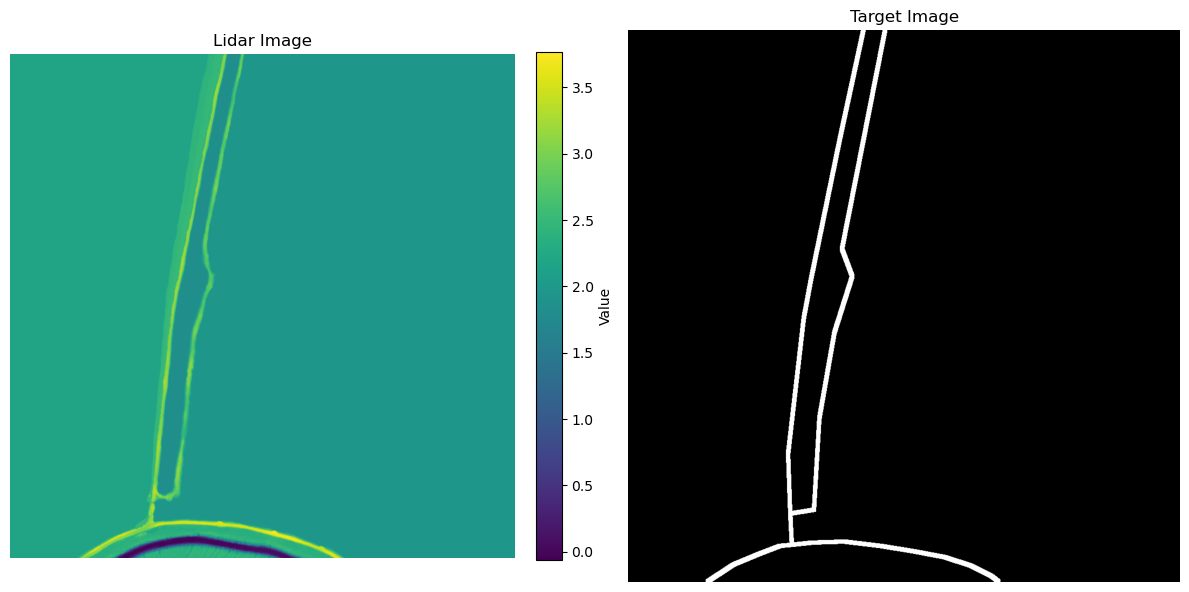

In [4]:
dataset.plot(idx=100, figsize=(12, 6), cmap='viridis', transform=False)

In [5]:
from levee_hunter.train_test_val_splitting import validation_split

file_ids = sorted(set(dataset.file_ids))[:45]
train_test_dataset, val_dataset = validation_split(dataset=dataset, file_ids=file_ids)

len(train_test_dataset), len(val_dataset)

(1423, 203)

In [6]:
from levee_hunter.train_test_val_splitting import train_test_split_dataset

train_dataset, test_dataset = train_test_split_dataset(dataset=train_test_dataset, test_size=0.07)

len(train_dataset), len(test_dataset), len(val_dataset)

(1323, 100, 203)

In [7]:
# we can check if their transformations are what we want them to be
train_dataset.transform, test_dataset.transform, val_dataset.transform

('train_transform', 'normalize_only', 'normalize_only')

In [8]:
# test and validation should be unweighted
test_dataset.weighted=False
val_dataset.weighted=False
train_dataset.weighted

True

In [9]:
batch_size = 14

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
# load the saved model
model.load_state_dict(torch.load("../models/1m_1024/Segformer-b0.pth"))
model.eval()

Segformer(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(1, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (block1): Sequential(
      (0): Block(
        (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=

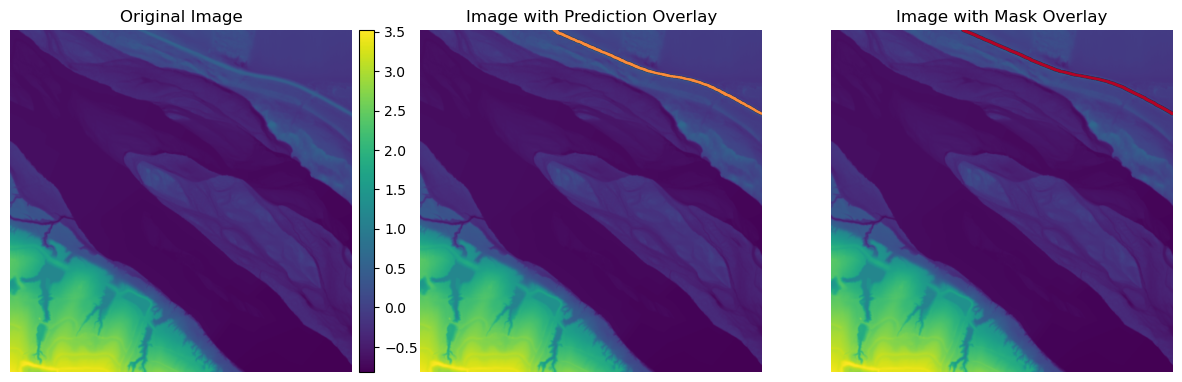

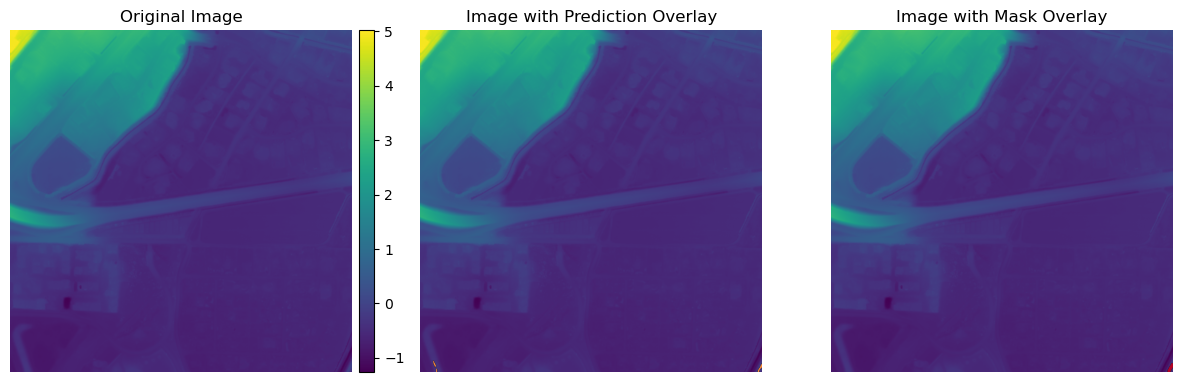

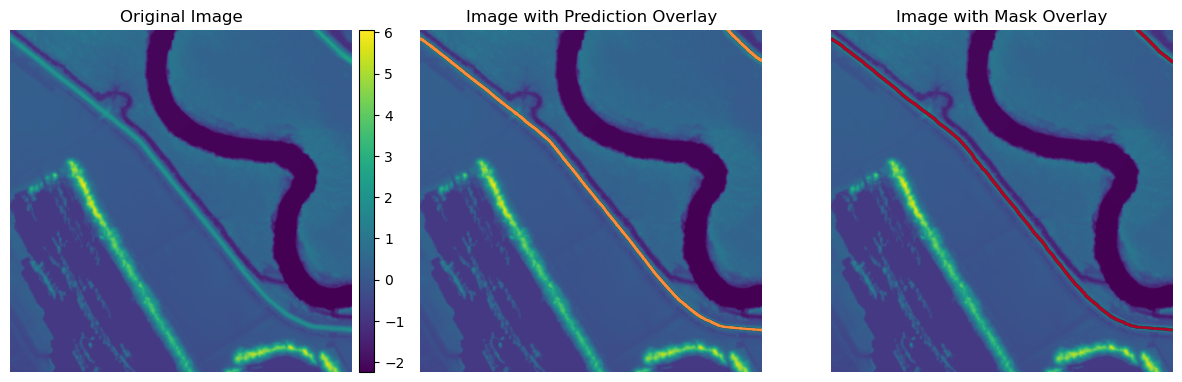

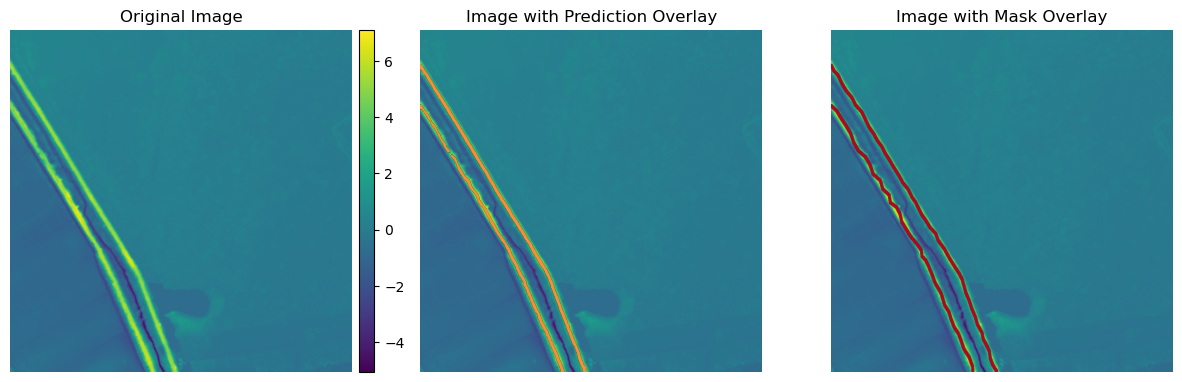

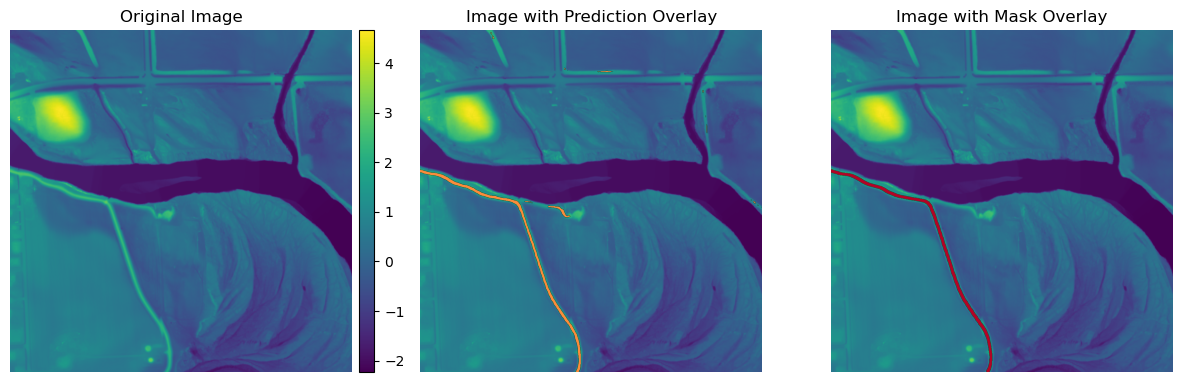

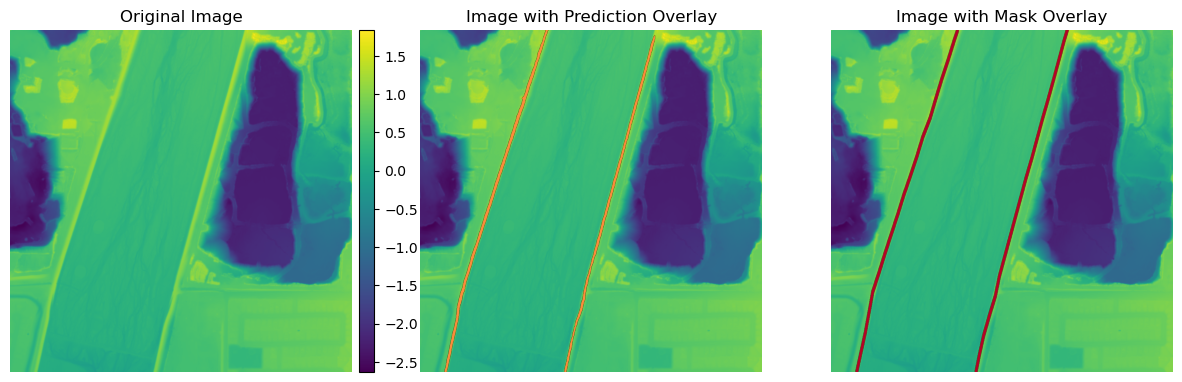

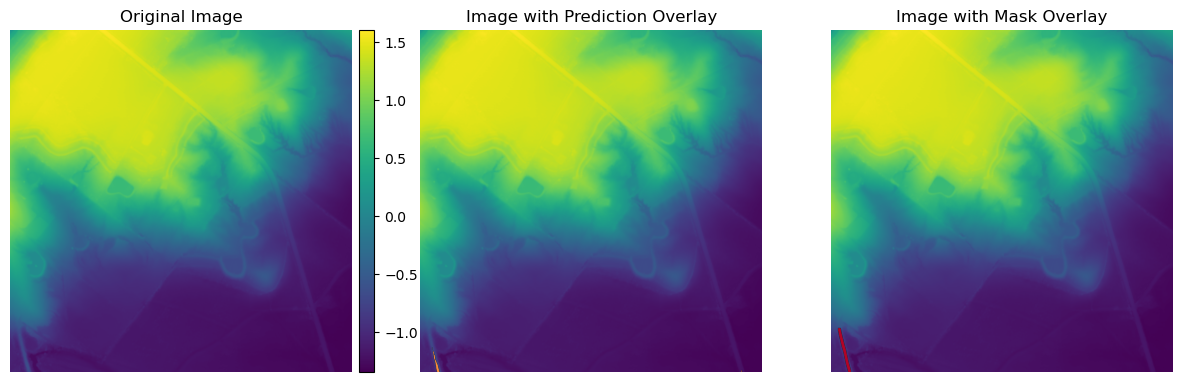

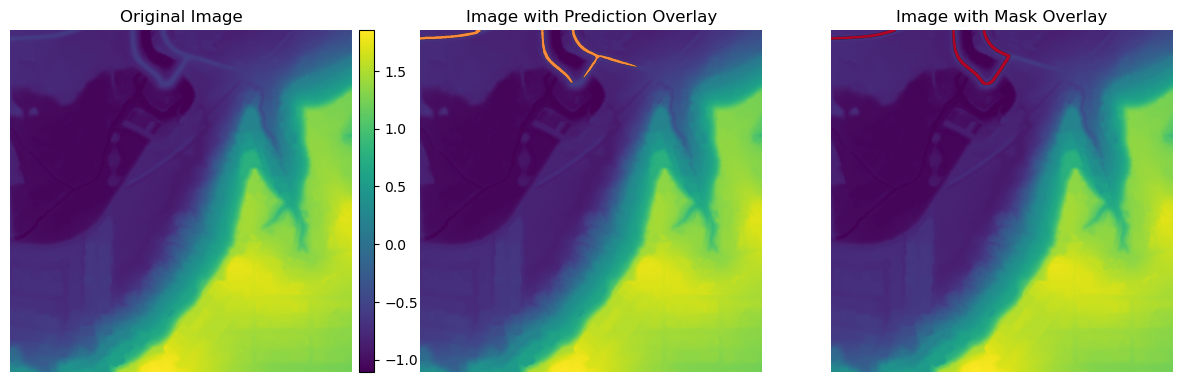

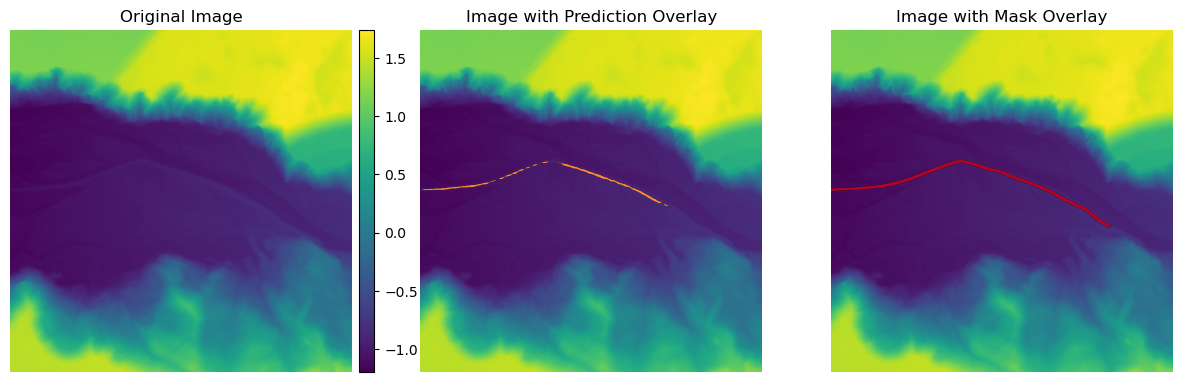

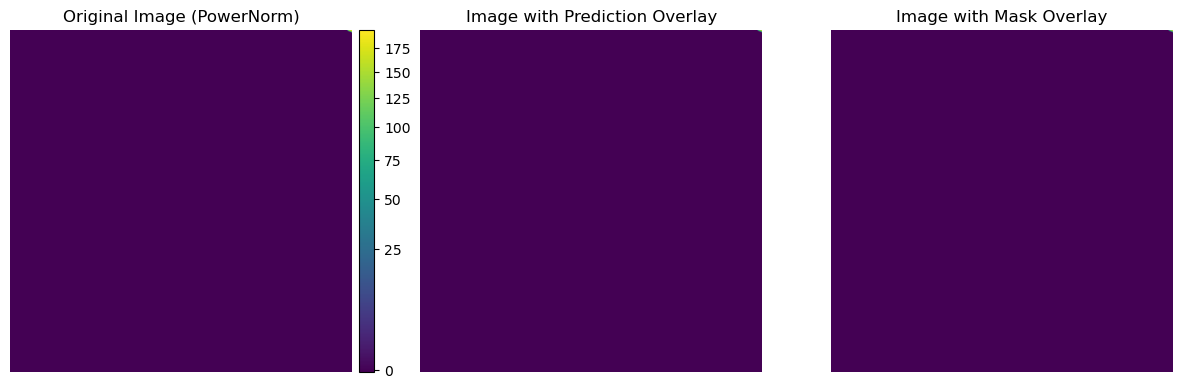

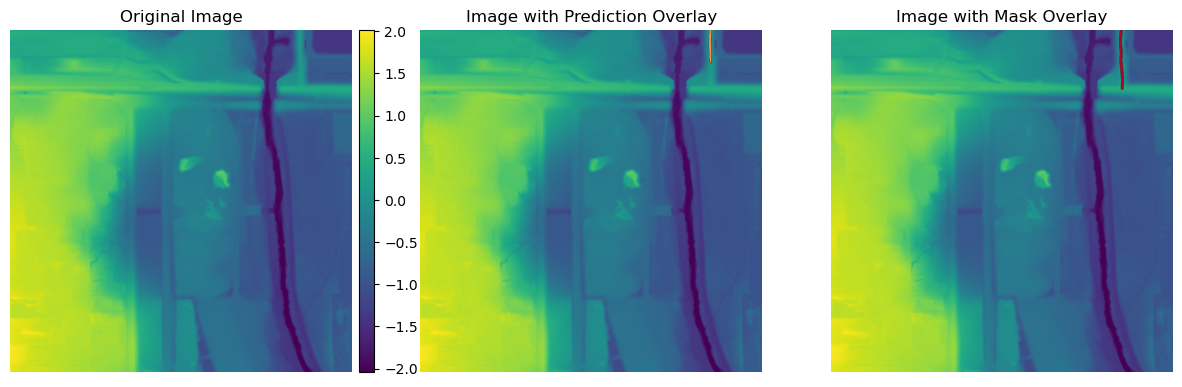

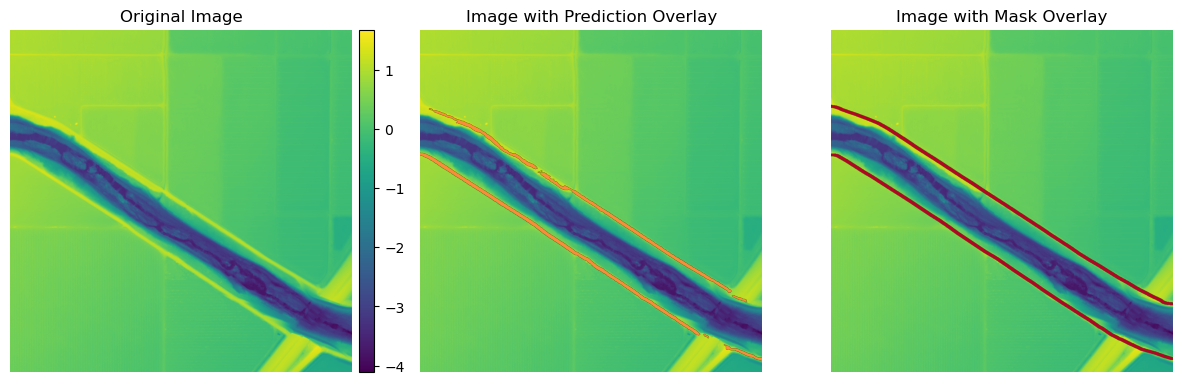

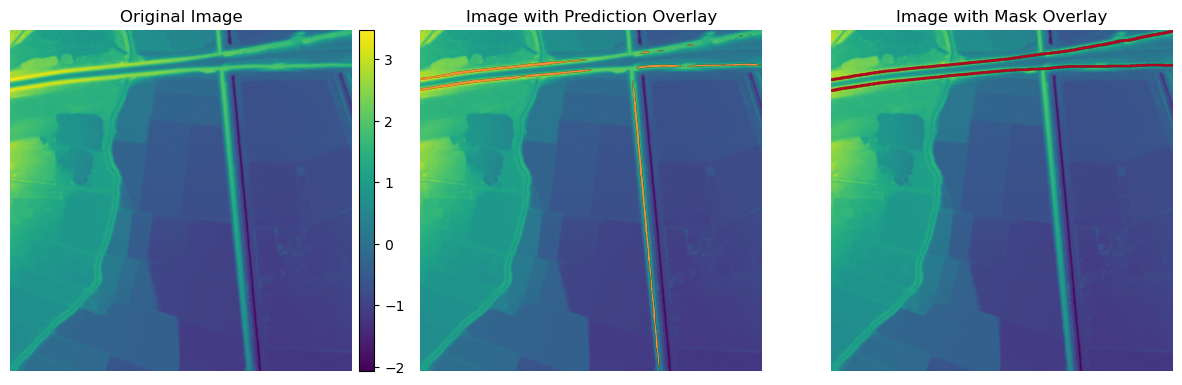

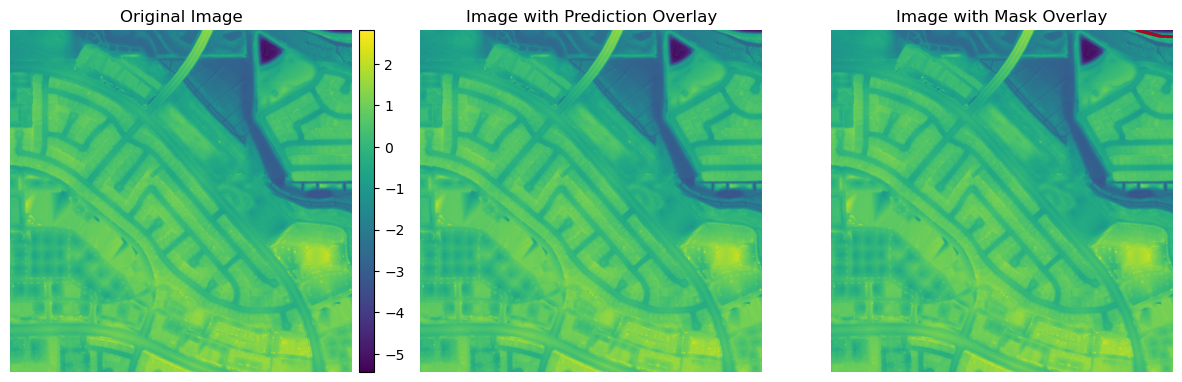

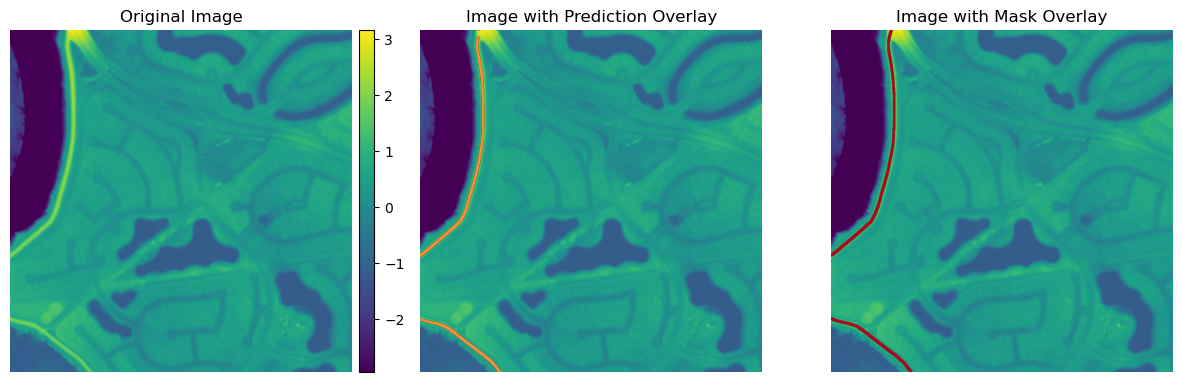

In [11]:
from levee_hunter.plotting import plot
from levee_hunter.modeling.inference import infer
for ix in range(15):
    sample_image, sample_mask = test_dataset[ix]
    prediction = infer(model=model, image=sample_image, device=device, apply_sigmoid=True, threshold=0.5)
    plot(image=sample_image, mask=sample_mask, pred=prediction, plot_types=['image', 'image_pred_overlay', 'image_mask_overlay'], powernorm_threshold=30)

In [28]:
from scipy.spatial.distance import directed_hausdorff
import numpy as np

def compute_hausdorff_distance(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """
    Compute the Hausdorff distance between two binary masks.
    
    Parameters:
        mask1, mask2: Binary numpy arrays (with 0 as background, nonzero as foreground).
        
    Returns:
        The Hausdorff distance between mask1 and mask2.
        If both masks are empty, returns 0.
        If only one is empty, returns np.nan.
    """
    pts1 = np.argwhere(mask1)
    pts2 = np.argwhere(mask2)
    
    if pts1.size == 0 and pts2.size == 0:
        return 0.0
    if pts1.size == 0 or pts2.size == 0:
        return np.nan

    d1 = directed_hausdorff(pts1, pts2)[0]
    d2 = directed_hausdorff(pts2, pts1)[0]
    
    return max(d1, d2)

In [12]:
from levee_hunter.modeling.inference import get_preds_targets
all_preds, all_targets = get_preds_targets(model=model, val_loader=val_loader, device=device, invert=True)

In [29]:
all_preds.shape, all_targets.shape

(torch.Size([203, 1, 1024, 1024]), torch.Size([203, 1, 1024, 1024]))

In [30]:
from levee_hunter.modeling.metrics import custom_metrics

import matplotlib.pyplot as plt
import numpy as np

# Initialize empty lists for each metric.
tp_list = []
fp_list = []
fn_list = []
iou_list = []
f1_list = []
recall_list = []
hausdorff_list = []

# Loop over all predictions and targets.
for i in range(len(all_preds)):
    pred = all_preds[i]
    target = all_targets[i]
    
    tp, fp, fn, iou_score, f1_score, recall = custom_metrics(
        targets=target,
        predictions=pred,
        d=13,
        d_merge=16,
        print_tp_fp_fn=False,
        return_values=True
    )
    
    # Append scalar values.
    tp_list.append(tp.item())
    fp_list.append(fp.item())
    fn_list.append(fn.item())
    iou_list.append(iou_score.item())
    f1_list.append(f1_score.item())
    recall_list.append(recall.item())
    
    # Convert predictions and targets to binary masks.
    # Assuming a threshold of 0.5.
    binary_pred = (pred > 0.5).cpu().numpy().squeeze()  # shape: (1024,1024)
    binary_target = (target > 0.5).cpu().numpy().squeeze()  # shape: (1024,1024)
    
    # Compute Hausdorff distance.
    hd = compute_hausdorff_distance(binary_pred, binary_target)
    hausdorff_list.append(hd)

-----------------------Custom Metrics-----------------------
IoU Score:         0.8858
F1 Score (Dice):   0.9394
Recall:            1.0000
------------------------------------------------------------
-----------------------Custom Metrics-----------------------
IoU Score:         0.6359
F1 Score (Dice):   0.7774
Recall:            0.6359
------------------------------------------------------------
-----------------------Custom Metrics-----------------------
IoU Score:         nan
F1 Score (Dice):   nan
Recall:            1.0000
------------------------------------------------------------
-----------------------Custom Metrics-----------------------
IoU Score:         nan
F1 Score (Dice):   nan
Recall:            1.0000
------------------------------------------------------------
-----------------------Custom Metrics-----------------------
IoU Score:         0.5657
F1 Score (Dice):   0.7226
Recall:            0.7651
------------------------------------------------------------
------------

In [31]:
iou_list[:10]

[0.8857589984350548,
 0.6358778625954199,
 nan,
 nan,
 0.5657142857142857,
 1.0,
 1.0,
 1.0,
 0.9643584521384929,
 0.2860103626943005]

In [32]:
iou_list = [1 if np.isnan(val) else val for val in iou_list]
f1_list = [1 if np.isnan(val) else val for val in f1_list]

In [33]:
iou_list[:10]

[0.8857589984350548,
 0.6358778625954199,
 1,
 1,
 0.5657142857142857,
 1.0,
 1.0,
 1.0,
 0.9643584521384929,
 0.2860103626943005]

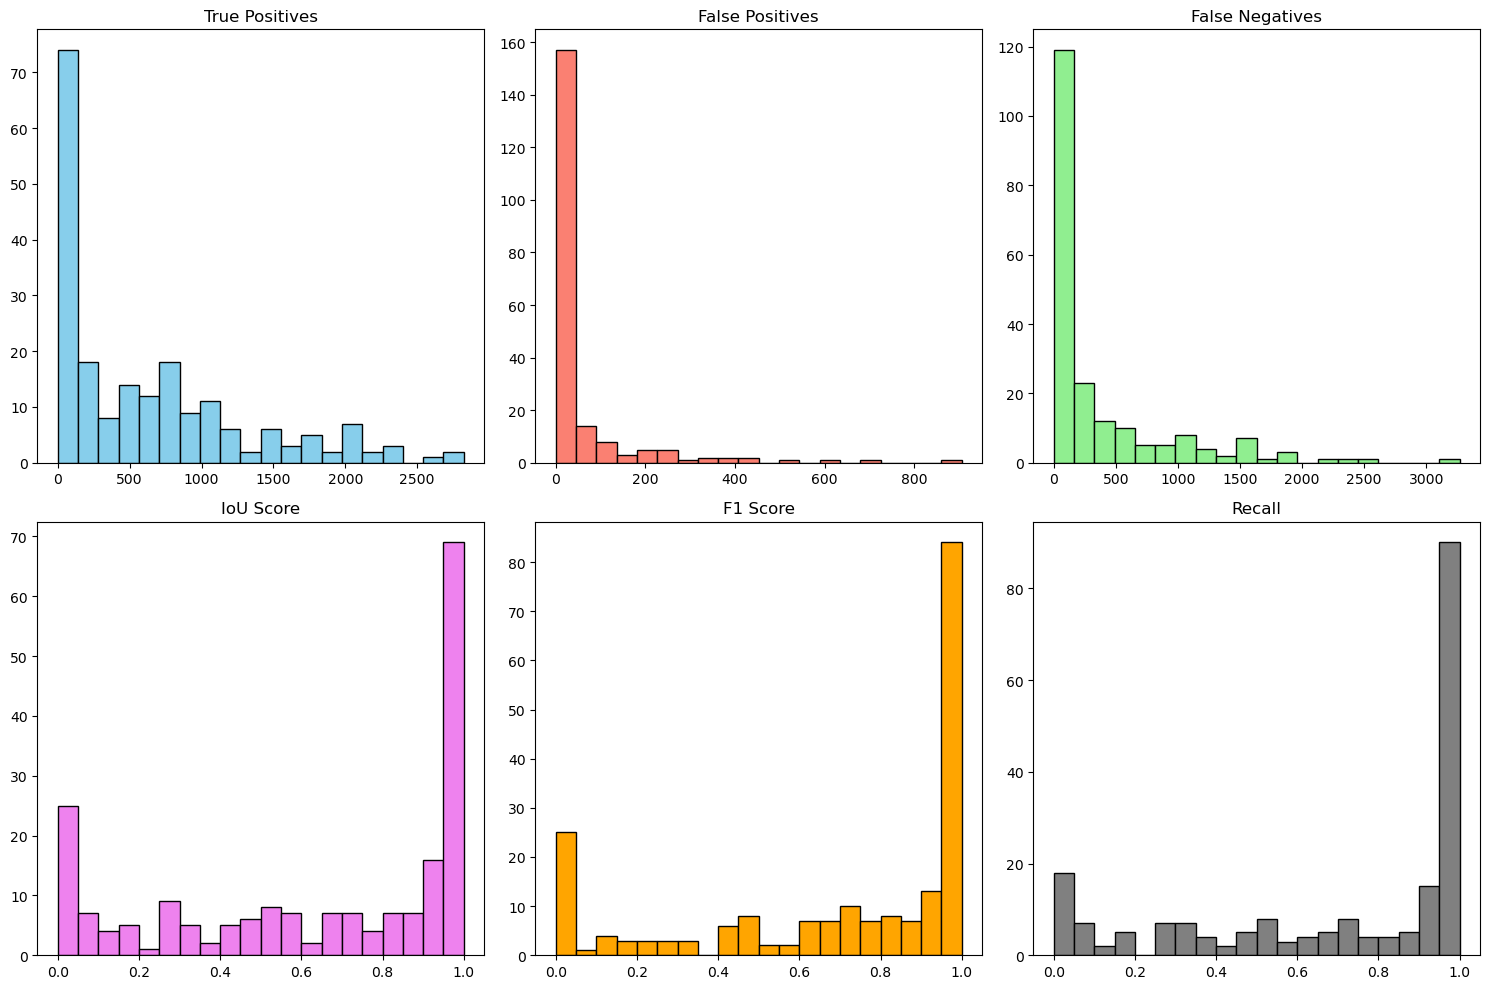

In [34]:
# Create a 2x3 subplot grid for histograms.
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()  # flatten the 2D array of axes for easier iteration

# Plot histograms for each metric.
axs[0].hist(tp_list, bins=20, color="skyblue", edgecolor="black")
axs[0].set_title("True Positives")

axs[1].hist(fp_list, bins=20, color="salmon", edgecolor="black")
axs[1].set_title("False Positives")

axs[2].hist(fn_list, bins=20, color="lightgreen", edgecolor="black")
axs[2].set_title("False Negatives")

axs[3].hist(iou_list, bins=20, color="violet", edgecolor="black")
axs[3].set_title("IoU Score")

axs[4].hist(f1_list, bins=20, color="orange", edgecolor="black")
axs[4].set_title("F1 Score")

axs[5].hist(recall_list, bins=20, color="gray", edgecolor="black")
axs[5].set_title("Recall")

plt.tight_layout()
plt.show()

(array([81., 26., 14., 15.,  9.,  7.,  7.,  6.,  5.,  4.,  0.,  1.,  2.,
         2.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([   0.        ,   69.10694611,  138.21389221,  207.32083832,
         276.42778442,  345.53473053,  414.64167663,  483.74862274,
         552.85556884,  621.96251495,  691.06946105,  760.17640716,
         829.28335326,  898.39029937,  967.49724547, 1036.60419158,
        1105.71113768, 1174.81808379, 1243.9250299 , 1313.031976  ,
        1382.13892211]),
 <BarContainer object of 20 artists>)

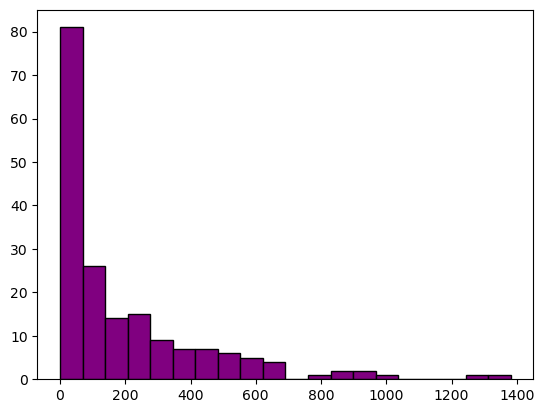

In [35]:
plt.hist(hausdorff_list, bins=20, color="purple", edgecolor="black")

In [36]:
hausdorff_list

[98.812954616285,
 259.7883754135277,
 0.0,
 0.0,
 241.6795398870165,
 7.0,
 3.1622776601683795,
 3.1622776601683795,
 28.160255680657446,
 618.4254199173898,
 134.73678042761748,
 155.7562197795003,
 0.0,
 0.0,
 122.40914998479485,
 4.123105625617661,
 451.9568563480368,
 441.8065187386895,
 12.0,
 111.80339887498948,
 0.0,
 138.2931668593933,
 75.18643494673756,
 39.6232255123179,
 570.6452488192642,
 3.0,
 69.58448102845921,
 296.1215966457023,
 8.54400374531753,
 505.1989707036229,
 49.57822102496216,
 53.075418038862395,
 4.0,
 182.02472359545007,
 55.78530272392541,
 912.4499986300619,
 313.7467131301936,
 476.68123520860354,
 689.1770454679987,
 0.0,
 58.89821729050889,
 116.73045875006231,
 82.37718130647589,
 0.0,
 1309.85342691463,
 119.4026800369238,
 nan,
 143.42245291445826,
 132.4009063413087,
 nan,
 195.0640920313116,
 68.8839603971781,
 0.0,
 190.8219064992277,
 81.98780397107853,
 83.67795408588812,
 0.0,
 338.97050019138834,
 nan,
 6.708203932499369,
 nan,
 0.0,
 208.

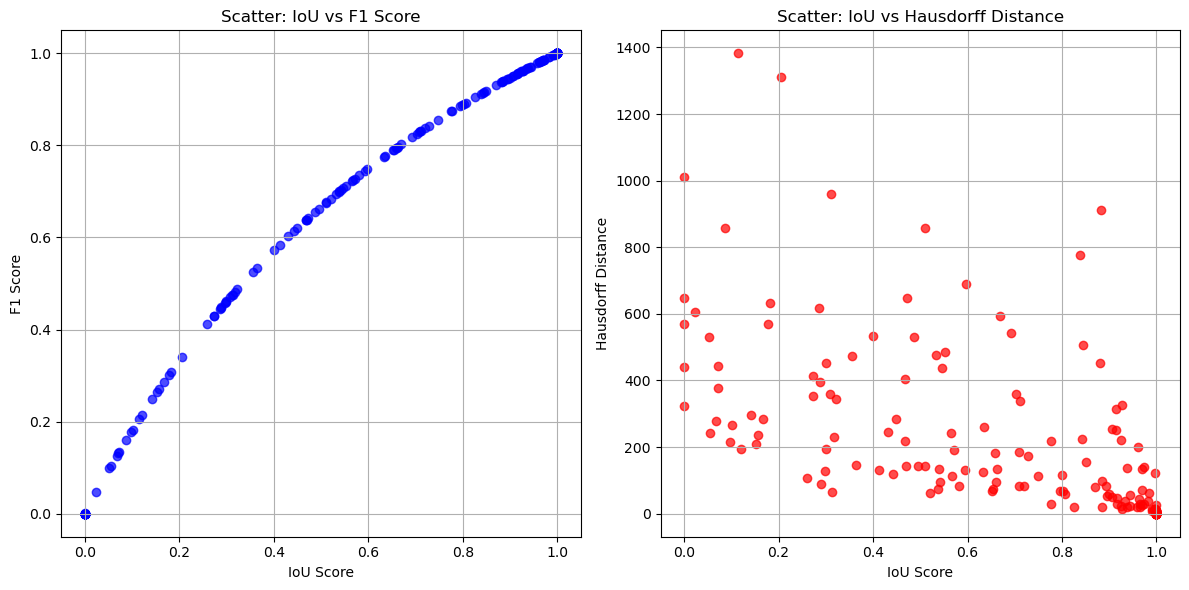

In [37]:
iou_array = np.array(iou_list)
hausdorff_array = np.array(hausdorff_list)

# Create a mask to filter out NaNs for the Hausdorff scatter.
mask = ~np.isnan(hausdorff_array)

# Create a figure with two subplots.
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot: IoU vs F1 Score.
axs[0].scatter(iou_list, f1_list, color='blue', alpha=0.7)
axs[0].set_xlabel("IoU Score")
axs[0].set_ylabel("F1 Score")
axs[0].set_title("Scatter: IoU vs F1 Score")
axs[0].grid(True)

# Scatter plot: IoU vs Hausdorff Distance.
axs[1].scatter(iou_array[mask], hausdorff_array[mask], color='red', alpha=0.7)
axs[1].set_xlabel("IoU Score")
axs[1].set_ylabel("Hausdorff Distance")
axs[1].set_title("Scatter: IoU vs Hausdorff Distance")
axs[1].grid(True)

plt.tight_layout()
plt.show()

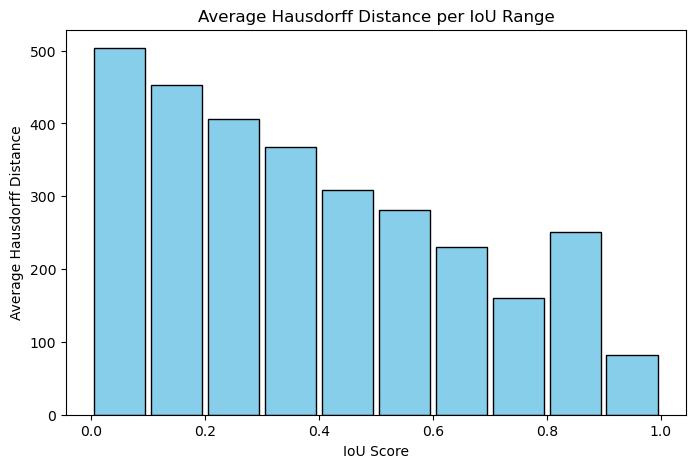

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Convert your lists to arrays.
iou_array = np.array(iou_list)
hausdorff_array = np.array(hausdorff_list)

# Optionally, filter out NaN Hausdorff values (if you want to ignore them)
valid = ~np.isnan(hausdorff_array)
iou_valid = iou_array[valid]
hausdorff_valid = hausdorff_array[valid]

# Define bins for the IoU score.
# For example, 10 bins between 0 and 1.
num_bins = 10
bins = np.linspace(0, 1, num_bins + 1)

# Get the bin index for each IoU value.
bin_indices = np.digitize(iou_valid, bins)

avg_hd_per_bin = []
bin_centers = []

for i in range(1, num_bins + 1):
    # Get a mask for the points that fall into the current bin.
    bin_mask = (bin_indices == i)
    if np.sum(bin_mask) > 0:
        avg_hd = np.mean(hausdorff_valid[bin_mask])
    else:
        avg_hd = np.nan  # or 0 if you prefer
    avg_hd_per_bin.append(avg_hd)
    
    # Calculate the center of the bin for plotting.
    center = (bins[i - 1] + bins[i]) / 2
    bin_centers.append(center)

# Plot as a bar chart.
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, avg_hd_per_bin, width=(bins[1]-bins[0])*0.9, color="skyblue", edgecolor="black")
plt.xlabel("IoU Score")
plt.ylabel("Average Hausdorff Distance")
plt.title("Average Hausdorff Distance per IoU Range")
plt.show()